In [1]:
import mlc_func as mlcf
import numpy as np
import pandas as pd
import keras
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
def create_target_file(baseline, reference, output, offset = 0):
    targets = np.genfromtxt(reference, delimiter = ',') -\
        np.genfromtxt(baseline, delimiter = ',') - offset
#     species = np.array(['o','h','h']*int(len(targets)/3)).reshape(-1,1)
#     targets = np.concatenate([targets,species], axis = 1)
    pd.DataFrame(targets).to_csv(output, index = None, header = None)

In [170]:
# basepath_feat = '../data/PBE/szp/basis_long_elf.json_processed/'
# basepath_tar = '../data/PBE/szp/'
# revpath_tar = '../data/MB-pol'

basepath_feat = '../data/PBE/dz_custom/basis_nocore_nn.json_processed/'
basepath_tar = '../data/PBE/dz_custom/'
revpath_tar = '../data/MB-pol/'

# systems = ['monomers','dimers','trimers']
systems = ['128']
mono_offset = 0
n_mol = [3,2,1]
filters = [([True,True] + [False]*10)*3000]
for s,nm in zip(systems, n_mol):
    create_target_file(basepath_tar +'/{}.forces'.format(s),
                      revpath_tar + '/{}.forces'.format(s),
                      basepath_tar +'/{}_targets.forces'.format(s), mono_offset*nm)
        
feature_src = [basepath_feat + s +'_processed.hdf5' for s in systems]
target_src = [basepath_tar +'/' + s +'_targets.forces' for s in systems]
traj_src = [basepath_tar +'/' + s +'.traj' for s in systems]
# # filters = [np.genfromtxt('../publication/data/filters/{}.filter'.format(s), dtype =bool) for s in systems]
nn = mlcf.ml.build_force_mlcf(feature_src, target_src,traj_src, filters =[], automask_std = 1e-3,
                                  autofilt_percent = 0.005, species = 'h')


{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
(2560, 8)


In [161]:
old_scaler = nn.scaler

In [162]:
nn.load_all('../../elf_models/mlcf_master/16p16/pbedz_mbp/')

/home/sebastian/miniconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [163]:
nn.X_test = nn.scaler.transform(old_scaler.inverse_transform(nn.X_test))

In [131]:
# nn.model = keras.models.load_model('../../elf_models/mlcf_master/16p16/pbesz_mbp_long/force_o')

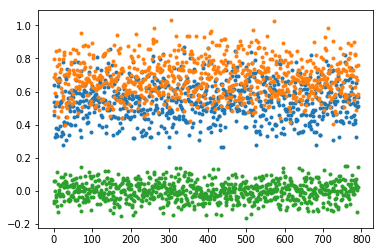

In [166]:
plot(nn.y_train,ls = '', marker = '.')


In [45]:
# learning_curve = nn.learning_curve(steps=8)

In [171]:
nn.nodes_per_layer = 16

In [172]:
nn.train(early_stopping=True, b=1e-8,batch_size=100, restart = False)

--------Epoch = 0----------
Training loss || Validation loss
     0.864108 ||      0.869828
--------Epoch = 500----------
Training loss || Validation loss
     0.046018 ||      0.047673


======== Evaluation on test set =============
              RMSE =  0.0446
              MAE = 0.0339
              Max. abs. error = 0.2396


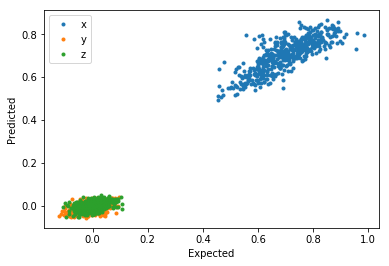

{'rmse': 0.04464917528990809,
 'mae': 0.03392512742313086,
 'max': 0.2395650039040118}

In [173]:
nn.evaluate(plot=True, on='test')

======== Evaluation on test set =============
              RMSE =  0.0692
              MAE = 0.0532
              Max. abs. error = 0.2747


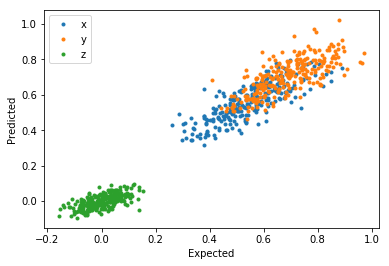

{'rmse': 0.06923821032218132,
 'mae': 0.05321703957790735,
 'max': 0.274726376662375}

In [169]:
nn.evaluate(plot=True, on='test')

In [153]:
nn.save_all('../../elf_models/mlcf_master/16p16/pbedz_mbp_mb/')

In [54]:
ensemble = mlcf.ml.Ensemble_Network(nn)

In [57]:
ensemble.train_next()

Training model: 2
--------Epoch = 0----------
Training loss || Validation loss
     0.690111 ||      0.689123
--------Epoch = 500----------
Training loss || Validation loss
     0.050323 ||      0.049841
--------Epoch = 1000----------
Training loss || Validation loss
     0.048252 ||      0.048288
--------Epoch = 1500----------
Training loss || Validation loss
     0.047829 ||      0.048089
--------Epoch = 2000----------
Training loss || Validation loss
     0.047680 ||      0.048073


KeyboardInterrupt: 

In [67]:
np.std(ensemble.std_predict(nn.X_test, processed=True), axis = 0)

array([0.00567823, 0.00177418, 0.00192366], dtype=float32)

In [23]:
force_model = {spec : mlcf.ml.load_force_model('../../elf_models/mlcf_master/16p16/pbedz_mbp/',spec)\
               for spec in ['o','h']}

predictions = {}
for spec in force_model:
    predictions[spec] = \
    force_model[spec].predict_from_hdf5('../data/PBE/dz_custom/basis_nocore_nn.json_processed/128_processed.hdf5')


predictions['o'].reshape

predictions = np.concatenate([predictions['o'], predictions['h'].reshape(*predictions['o'].shape[:2],6)],
                            axis = -1)

predictions = predictions.reshape(*predictions.shape[:2],3,3)

/home/sebastian/miniconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}


In [27]:
pbe = np.genfromtxt('../data/PBE/dz_custom/128.forces', delimiter = ',').reshape(-1,128,3,3)
mbp = np.genfromtxt('../data/MB-pol/128.forces', delimiter = ',').reshape(-1,128,3,3)
corrected = pbe + predictions


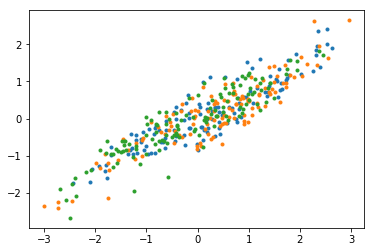

In [30]:
plot(mbp[0,:,0],pbe[0,:,0], ls = '' , marker = '.')

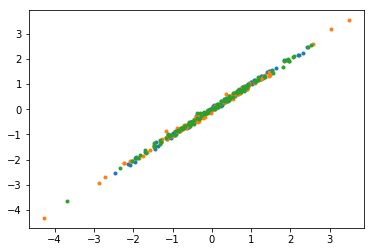

In [32]:
plot(mbp[1,:,0],corrected[1,:,0], ls = '', marker = '.')

In [47]:


[np.sum(np.sum(corrected[:i,:,:].reshape(-1,128,3), axis = 1), axis =0) for i in range(1,len(corrected))]

[array([0.40224509, 1.90458897, 0.55260751]),
 array([ 0.58359954,  2.62904081, -0.26304139]),
 array([-0.05226126,  2.67297274,  0.04634111]),
 array([-0.19009606,  1.71338263, -0.01963356]),
 array([-0.00679624,  1.52289091,  0.30724766]),
 array([0.1727576 , 1.65949262, 0.37979874]),
 array([ 0.22017062,  1.58973079, -0.64035414]),
 array([ 0.10004467,  0.77187416, -2.34017531]),
 array([-0.11286136,  0.6876175 , -2.92732418])]

In [39]:
np.sum(mbp[1,:,:].reshape(-1,3), axis = 0)

array([7.84701631e-05, 9.69849383e-05, 8.07196580e-05])

In [40]:
np.sum(pbe[1,:,:].reshape(-1,3), axis = 0)

array([ 0.007643, -0.073615,  0.010096])